In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
# Logsumexp function
from scipy.misc import logsumexp
# gaussian pdf
from scipy.stats import multivariate_normal

In [201]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%precision %.5e
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['legend.fontsize'] = 30
plt.rc('text', usetex=True)
plt.rc('font',**{'family':'serif','serif':['Palatino']})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
# Show the current print options
np.get_printoptions()

{'edgeitems': 3,
 'formatter': None,
 'infstr': 'inf',
 'linewidth': 75,
 'nanstr': 'nan',
 'precision': 5,
 'suppress': False,
 'threshold': 1000}

In [105]:
np.set_printoptions(precision = 5)

# Tools

In [52]:
from tools.graphics import as_si, make_grid, plot_data, plot_frontiere, plot_cov_ellipse
from tools.mixture import K_means, GM

# Constants

In [53]:
DATA_DIR = "data/"
COLS = ["red", "blue","green", "orange", "black", "cyan"]
MARKS = ["^","+","*","o","x","."]

## Reading data

In [54]:
D = {}
for t in ["data", "test"]:
    D[t] = pd.read_csv(DATA_DIR + "EMGaussian" + "." + t, sep = ' ', names = ["x1", "x2"])

In [55]:
len(D["test"])

500

## Previously found gaussiens

### Previous parameters found

In [537]:
previous_params = np.load("mixture_parameters.npy").item()
previous_params

{'mu': array([[-3.0599 , -3.5326 ],
        [-2.03408,  4.17288],
        [ 3.98082,  3.83154],
        [ 3.79965, -3.77777]]), 'sigma': array([[[  6.25185,   6.05995],
         [  6.05995,   6.19158]],
 
        [[  2.90574,   0.20778],
         [  0.20778,   2.75669]],
 
        [[  0.20862,   0.27747],
         [  0.27747,  11.97735]],
 
        [[  0.91297,   0.05585],
         [  0.05585,   1.90662]]])}

### Generate multivariate gaussien from those parameters

In [538]:
emission = np.array([multivariate_normal(previous_params["mu"][key], previous_params["sigma"][key])
           for key in range(previous_params["mu"].shape[0])])

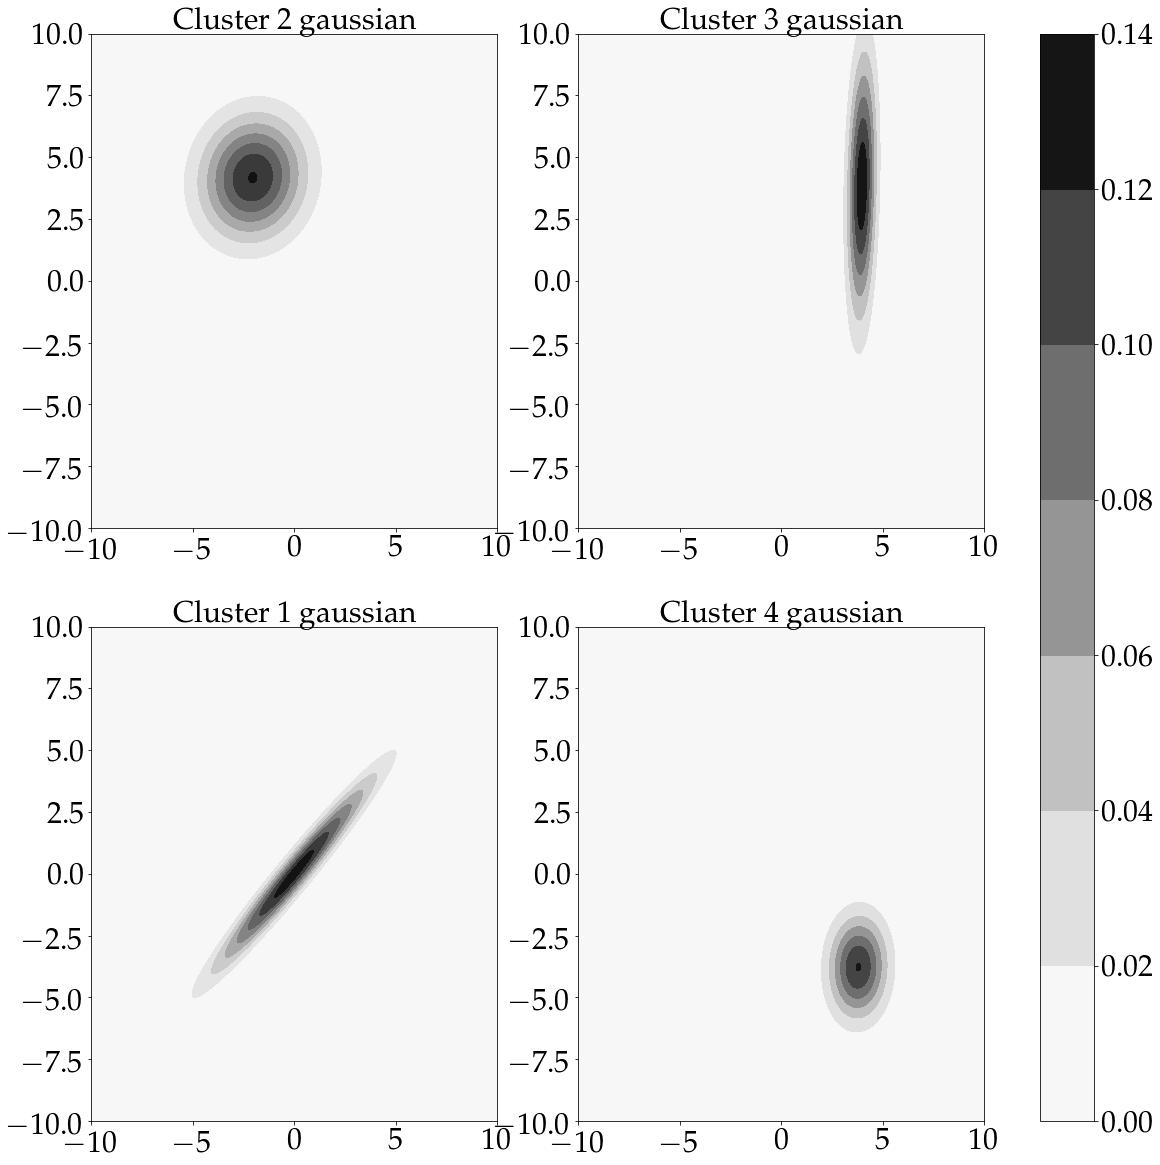

In [490]:
x, y = np.mgrid[-10:10:.01, -10:10:.01]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
cmap = 'Greys'

f, ax = plt.subplots(2, 2, figsize = (20, 20));
im1 = ax[1][0].contourf(x, y, emission[0].pdf(pos), cmap = cmap);
ax[1][0].set_title("Cluster 1 gaussian");
ax[0][0].contourf(x, y, emission[1].pdf(pos), cmap = cmap);
ax[0][0].set_title("Cluster 2 gaussian");
ax[0][1].contourf(x, y, emission[2].pdf(pos), cmap = cmap);
ax[0][1].set_title("Cluster 3 gaussian");
im4 = ax[1][1].contourf(x, y, emission[3].pdf(pos), cmap = cmap);
ax[1][1].set_title("Cluster 4 gaussian");
plt.colorbar(im4, ax = ax);

# HMM - implementation

In [556]:
class HMM(object):
    """
    HMM handmade class
    """

    def __init__(self, u, nbr_states, emission, A = None, pi = None):
        """
        Parameters:
        -----------
        u:                   array-like, shape (T,d)
                             T observations of d dimension
        nbr_states:          positive integer
                             number of hidden states
        emission:            array of variables
                             emission probability distributions
        A:                   array
                             state transition matrix
        pi:                  array-like, shape(nbr_states,)
                             initial state distribution
        """
        # Observations
        self.u = u
        # Model constants
        self.T = u.shape[0]
        self.d = u.shape[1]
        self.M = nbr_states
        # Model parameters
        self.pi = pi
        self.A = A
        self.O = emission
        if len(self.O) != self.M:
            raise ValueError("Number of states {} and number of emission {}"
            "distributions do not match.".format(self.M, len(self.O)))
        if A is not None:
            if A.shape[0] != A.shape[1] or not (np.round(A.sum(0), 3) == [1] * nbr_states).all():
                raise ValueError("A is not a valid transition matrix")
        if pi is not None:
            if len(pi) != nbr_states:
                raise ValueError("Number of states {} and length of distribution of initial states {}"
                                 "do not match".format(self.M, len(self.pi)))
        # Variables for recursions (inference and expectation step)
        self.alphas = None
        self.betas = None
        self.alphas_norm = None
        self.gammas = None
        self.xis = None
        # Complete log-likelihood
        self.likelihood = []
        return

    def _check_parameters(self):
        """
        Checking needed parameters for inference tasks
        """
        if self.A is None:
            raise ValueError("State transition matrix is empty")
        elif self.pi is None:
            raise ValueError("Initial state distribution is unknown")
        return
    
    def _alpha_beta_recusion(self, check_value = True):
        """
        Checking if alpha or beta recursion has to be done
        """
        if self.alphas is None:
            self._alpha_recursion()
        elif self.betas is None:
            self._beta_recursion()

    def _alpha_recursion(self):
        """
        Alpha recursion
        ---------------
        """
        # Can't do inference if A or pi is missing
        self._check_parameters()
        alphas = np.zeros((self.M, self.T))
        # Initialization of alphas
        alphas[:, 0] = np.log(self.pi * np.array([self.O[i].pdf(self.u[0]) for i in range(self.M)]))
        # For the t_th observation
        for t in range(1, self.T):
            # Compute the path for the i_th state
            for i in range(self.M):
                alphas[i, t] = np.log(self.O[i].pdf(self.u[t])) + logsumexp(alphas[:, t - 1], b = A[:, i])
        self.alphas = alphas
        return

    def _alpha_norm_recursion(self):
        """
        Alpha normalized recursion
        """
        # Can't do inference if A or pi is missing
        self._check_parameters()
        alphas_norm = np.zeros((self.M, self.T))
        # Initialization of alphas
        alphas_norm[:, 0] = self.pi * np.array([self.O[i].pdf(self.u[0]) for i in range(self.M)])
        alphas_norm[:, 0] /= alphas_norm[:, 0].sum()
        # For the t_th observation
        for t in range(1, self.T):
            # Compute the path for the i_th state
            for i in range(self.M):
                alphas_norm[i, t] = self.O[i].pdf(self.u[t]) * (alphas_norm[:, t - 1] * A[:, i]).sum()
            alphas_norm[:, t] /= alphas_norm[:, t].sum()
        self.alphas_norm = alphas_norm
        return

    def _beta_recursion(self):
        """
        Beta recursion
        --------------
        """
        # Can't do inference if A or pi is missing
        self._check_parameters()
        betas = np.zeros((self.M, self.T))
        # Initialization of betas (to 0 because we take the log)
        betas[:, self.T - 1] = [0] * self.M
        # For the t_th observation
        for t in range(self.T - 2, -1, -1):
            # Compute the path for the i_th state
            for i in range(self.M):
                betas[i, t] = logsumexp(betas[:, t + 1],
                                        b = A[i, :] * [self.O[q].pdf(self.u[t + 1]) for q in range(self.M)])
        self.betas = betas
        return
    def _smoothing(self, t, check = True):
        """
        Inference task: smoothing
        Find the distribution of the hidden state at t given the actual observations
        """
        # Compute alphas and betas if needed
        if check == True:
            self._alpha_beta_recusion()
        return self.alphas[:, t] + self.betas[:, t] - logsumexp(self.alphas[:, -1])

    def _smoothing_all(self, check = True):
        """
        Inference task: smoothing
        Find the distribution of the hidden state at t given the actual observations
        """
        if check:
            self._alpha_beta_recusion()
        
        self.smoothing_all = np.array([self._smoothing(t, check = False) for t in range(self.T)]).T
        if (np.round(np.exp(self.smoothing_all).sum(0), 3) != 1).any():
            raise ValueError("Numerical approximations failed, please be careful with next results")

    def _gamma_recursion(self):
        """
        Gamma recursion
        Using normalized alpha recursion
        ---------------
        """
        # Can't do inference if A is missing
        self._check_parameters()
        # Use normalized alphas to avoid numerical issues
        self._alpha_norm_recursion()
        # Initialization
        gammas = np.zeros((self.M, self.T))
        gammas[:, -1] = self.alphas_norm[:, -1]
        # For the t_th observation
        for t in range(self.T - 2, -1, -1):
            # Compute the path for the i_th state
            for i in range(self.M):
                gammas[i, t] = float(np.array([self.alphas_norm[i, t] * A[i, j] * gammas[j, t + 1] \
                               / (self.alphas_norm[:, t] * A[:, j]).sum() for j in range(self.M)]).sum())
        self.gammas = gammas
        return

    def _xi_recursion(self):
        """
        Xi recursion
        Using normalized alpha recursion
        """
        # Can't do inference if gamma has not been computed yet
        if self.gammas is None:
            self._gamma_recursion()
        # Can't do inference if alphas has not been computed yet too
        if self.alphas is None:
            self._alpha_recursion()
        # Initialization
        xis = np.zeros((self.T - 1, self.M, self.M))
        # for the t_th observation
        for t in range(self.T - 1):
            for i in range(self.M):
                for j in range(self.M):
                    xis[t, i, j] = self.alphas_norm[i, t] * self.O[j].pdf(self.u[t + 1])\
                                   * self.gammas[j, t + 1] * A[i, j] \
                                   * np.exp(logsumexp(self.alphas[:, t]) - logsumexp(self.alphas[:, t + 1]))\
                                   / self.alphas_norm[j, t + 1]
        self.xis = xis
        return

    def _e_step(self):
        """
        Expectation step
        ----------------
        """
        self._alpha_recursion()
        # Compute incomplete log_likelihood
        self._log_likelihood_complete()
        self._alpha_norm_recursion()
        self._gamma_recursion()
        self._xi_recursion()

        return

    def _m_step(self):
        """
        Maximization step
        -----------------
        """
        # Pi update
        self.pi = self.gammas[:, 0]
        # A update
        self.A = self.xis.sum(0) / self.gammas.sum(1).reshape(-1, 1)
        # Emission parameters update
        params = {"mu" : np.array([(hmm.gammas[k, :].reshape(-1, 1) * hmm.u).sum(0)\
                                   / hmm.gammas[k, :].sum() for k in range(self.M)]),
                  "sigma" : np.array([(hmm.gammas[k, :].reshape(1, -1) * ((hmm.u - hmm.O[k].mean).T))\
                       .dot((hmm.u - hmm.O[k].mean)) / hmm.gammas[k, :].sum() for k in range(self.M)])}
        self.O = np.array([multivariate_normal(params["mu"][key], params["sigma"][key])
           for key in range(params["mu"].shape[0])])
        return

    def _log_likelihood_incomplete(self):
        """
        Compute incomplete log-likelihood
        """
        self.likelihood.append(logsumexp(self.alphas[:, -1]))
        return 

    def _log_likelihood_complete(self):
        """
        Compute the complete log-likelihood
        """
        
        return

    def _EM(self, A, pi, emission):
        """
        Learning parameters with Expectation-Maximization algorithm
        (Only works for gaussian emission)
        -----------------------------------------------------------
        
        """
        # Initial start
        self.A = A
        self.pi = pi
        self.O = emission
        # Stop condition
        stop = False
        while (stop == False):
            self._e_step()
            self._m_step()
            print (self.likelihood[-1])
            if (len(self.likelihood) > 2 and np.abs(self.likelihood[-2] - self.likelihood[-1]) < 1e-3):
                stop = True
        return

In [371]:
HMM(np.zeros((10, 1)), 5, {0: "test", 1: "test", 2: "test", 3: "test", 4: "test"})

We consider the following HMM model : the chain (q t ) has K = 4 possible states,
with an initial probability distribution π ∈ R 4 and a probability transition matrix
A ∈ R 4×4 , and conditionally on the current states we have observations obtained from
Gaussian emission probabilities u t |q t = i ∼ N (μ i , Σ i ).

## 1. $\alpha$ and $\beta$ recursion
Implement the recursions α et β seen in class (and that can be found in the
polycopié as well) to compute p(q t |u 1 , . . . , u T ) and p(q t , q t+1 |u 1 , . . . , u T ).

In [251]:
pi = [1/4] * 4
print ("pi\n", pi)

A = np.zeros((4,4)) + 1/6
np.fill_diagonal(A, 1/2)
print ("A\n", A)

pi
 [0.25, 0.25, 0.25, 0.25]
A
 [[ 0.5      0.16667  0.16667  0.16667]
 [ 0.16667  0.5      0.16667  0.16667]
 [ 0.16667  0.16667  0.5      0.16667]
 [ 0.16667  0.16667  0.16667  0.5    ]]


## 2. $p(q_t \mid u_1, \dots, u_T)$ using $\alpha$ and $\beta$ recursion
Using the same parameters for the means and covariance matrix of the 4 Gaus-
sians as the ones obtained in the previous homework, taking a uniform initial
probability distribution $\pi$, and setting A to be the matrix with diagonal coef-
ficients $A_{ii} = \frac{1}{2}$ and off-diagonal coefficients $A_{ij} = \frac{1}{6} \forall (i, j) \in [1, \dots , 4]^2$ , compute $\alpha_t$ and $\beta_t$ for all t on the test data (_EMGaussienne.test_ file) and
compute $p(q_t \mid u_1, \dots, u_T)$. Finally, represent $p(q_t \mid u_1, \dots, u_T)$ for each of the 4
states as a function of time for the 100 first datapoints in the file. Note that only the 100 first points should be plotted by that filtering should be done with all the data (i.e. T = 500). This will be the same for the subsequent questions.

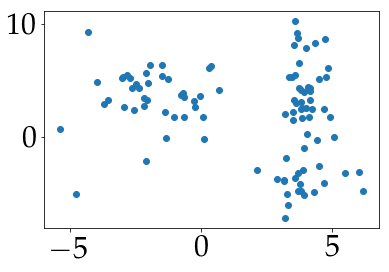

In [252]:
# First 100 points of the test dataset
first_100 = D["test"].as_matrix()[:100]
plt.scatter(first_100[:, 0], first_100[:, 1]);

In [295]:
hmm = HMM(D["test"].as_matrix(), 4, emission, A = A, pi = pi)
hmm._alpha_recursion()
hmm._alpha_norm_recursion()
hmm._beta_recursion()
hmm._smoothing_all()

alpha = np.exp(hmm.alphas)
beta = np.exp(hmm.betas)
smoothing = hmm.smoothing_all

smoothing

array([[ -1.90998e-08,  -1.38747e-04,  -2.72649e+01, ...,  -1.41935e-07,
         -1.58252e-10,  -9.22273e-09],
       [ -1.77737e+01,  -8.88293e+00,  -9.82848e+00, ...,  -1.57679e+01,
         -2.25693e+01,  -1.85016e+01],
       [ -1.85066e+02,  -8.84703e+01,  -1.58473e-01, ...,  -1.40154e+02,
         -1.98738e+02,  -1.79208e+02],
       [ -4.12102e+01,  -2.04557e+01,  -1.92073e+00, ...,  -3.20514e+01,
         -4.50582e+01,  -4.00038e+01]])

In [171]:
# # Verify computation: check if (alphas * betas).sum(0) is everywhere equal to np.exp(hmm.alphas[:, -1]).sum(0)
# p_u = np.exp(hmm.alphas[:, -1]).sum(0)
# p_u

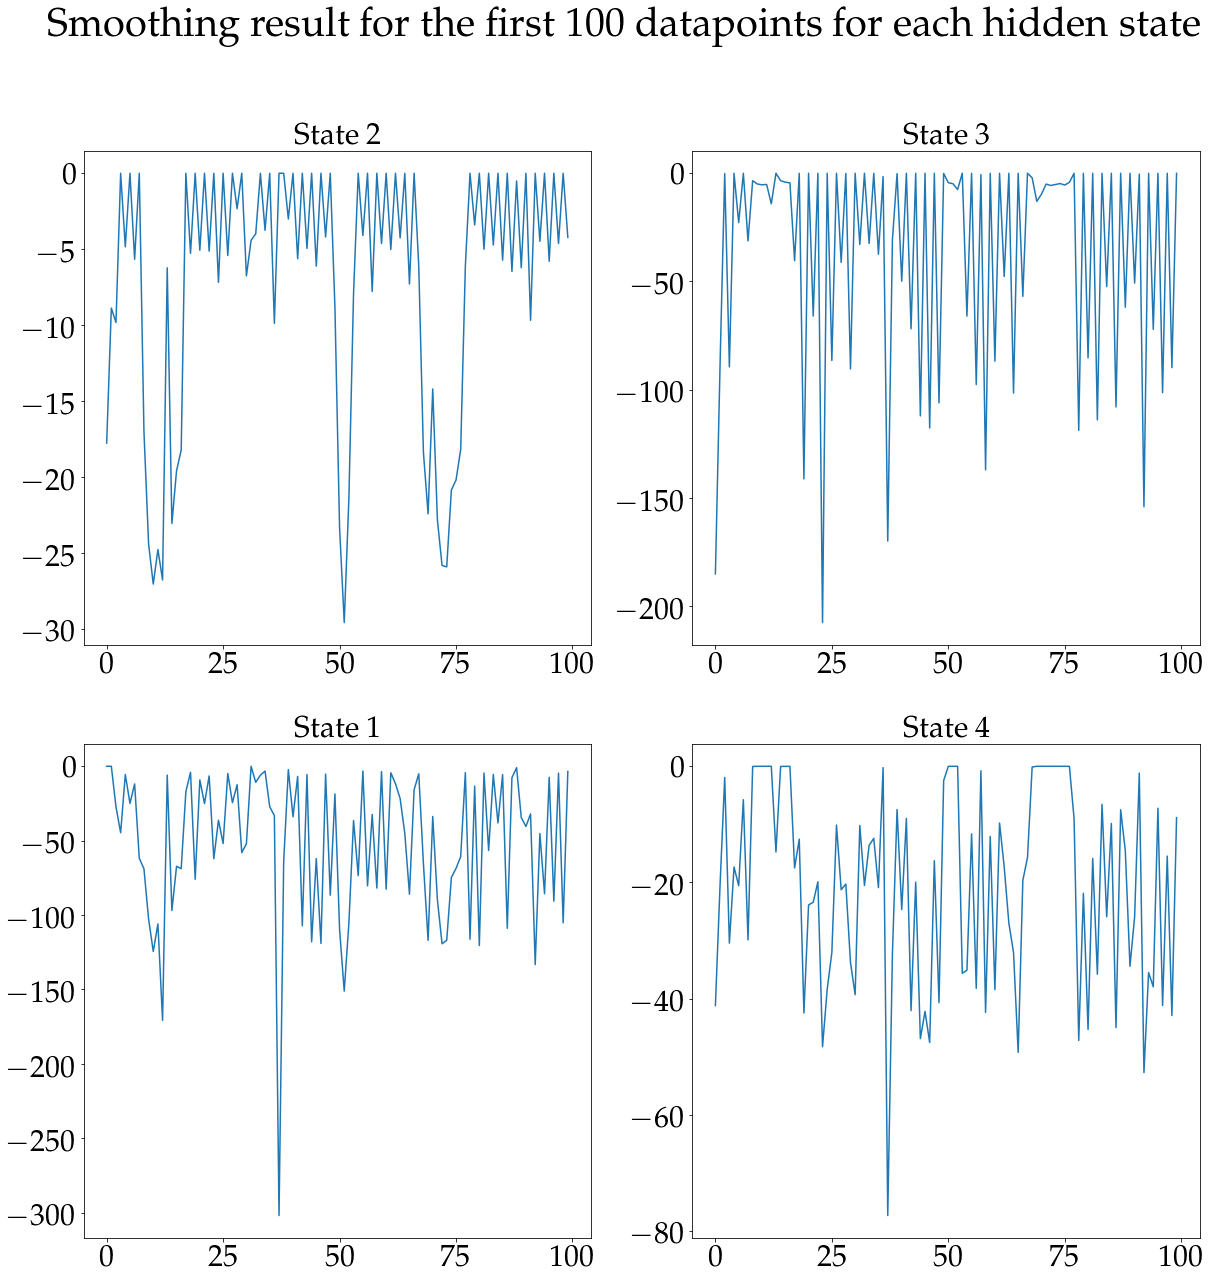

In [254]:
f, ax = plt.subplots(2, 2, figsize = (20, 20));
im1 = ax[1][0].plot(smoothing[0, :100]);
ax[1][0].set_title("State 1");
ax[0][0].plot(smoothing[1, :100]);
ax[0][0].set_title("State 2");
ax[0][1].plot(smoothing[2, :100]);
ax[0][1].set_title("State 3");
im4 = ax[1][1].plot(smoothing[3, :100]);
ax[1][1].set_title("State 4");
f.suptitle("Smoothing result for the first 100 datapoints for each hidden state", size = 40);

In [224]:
COLS

['red', 'blue', 'green', 'orange', 'black', 'cyan']

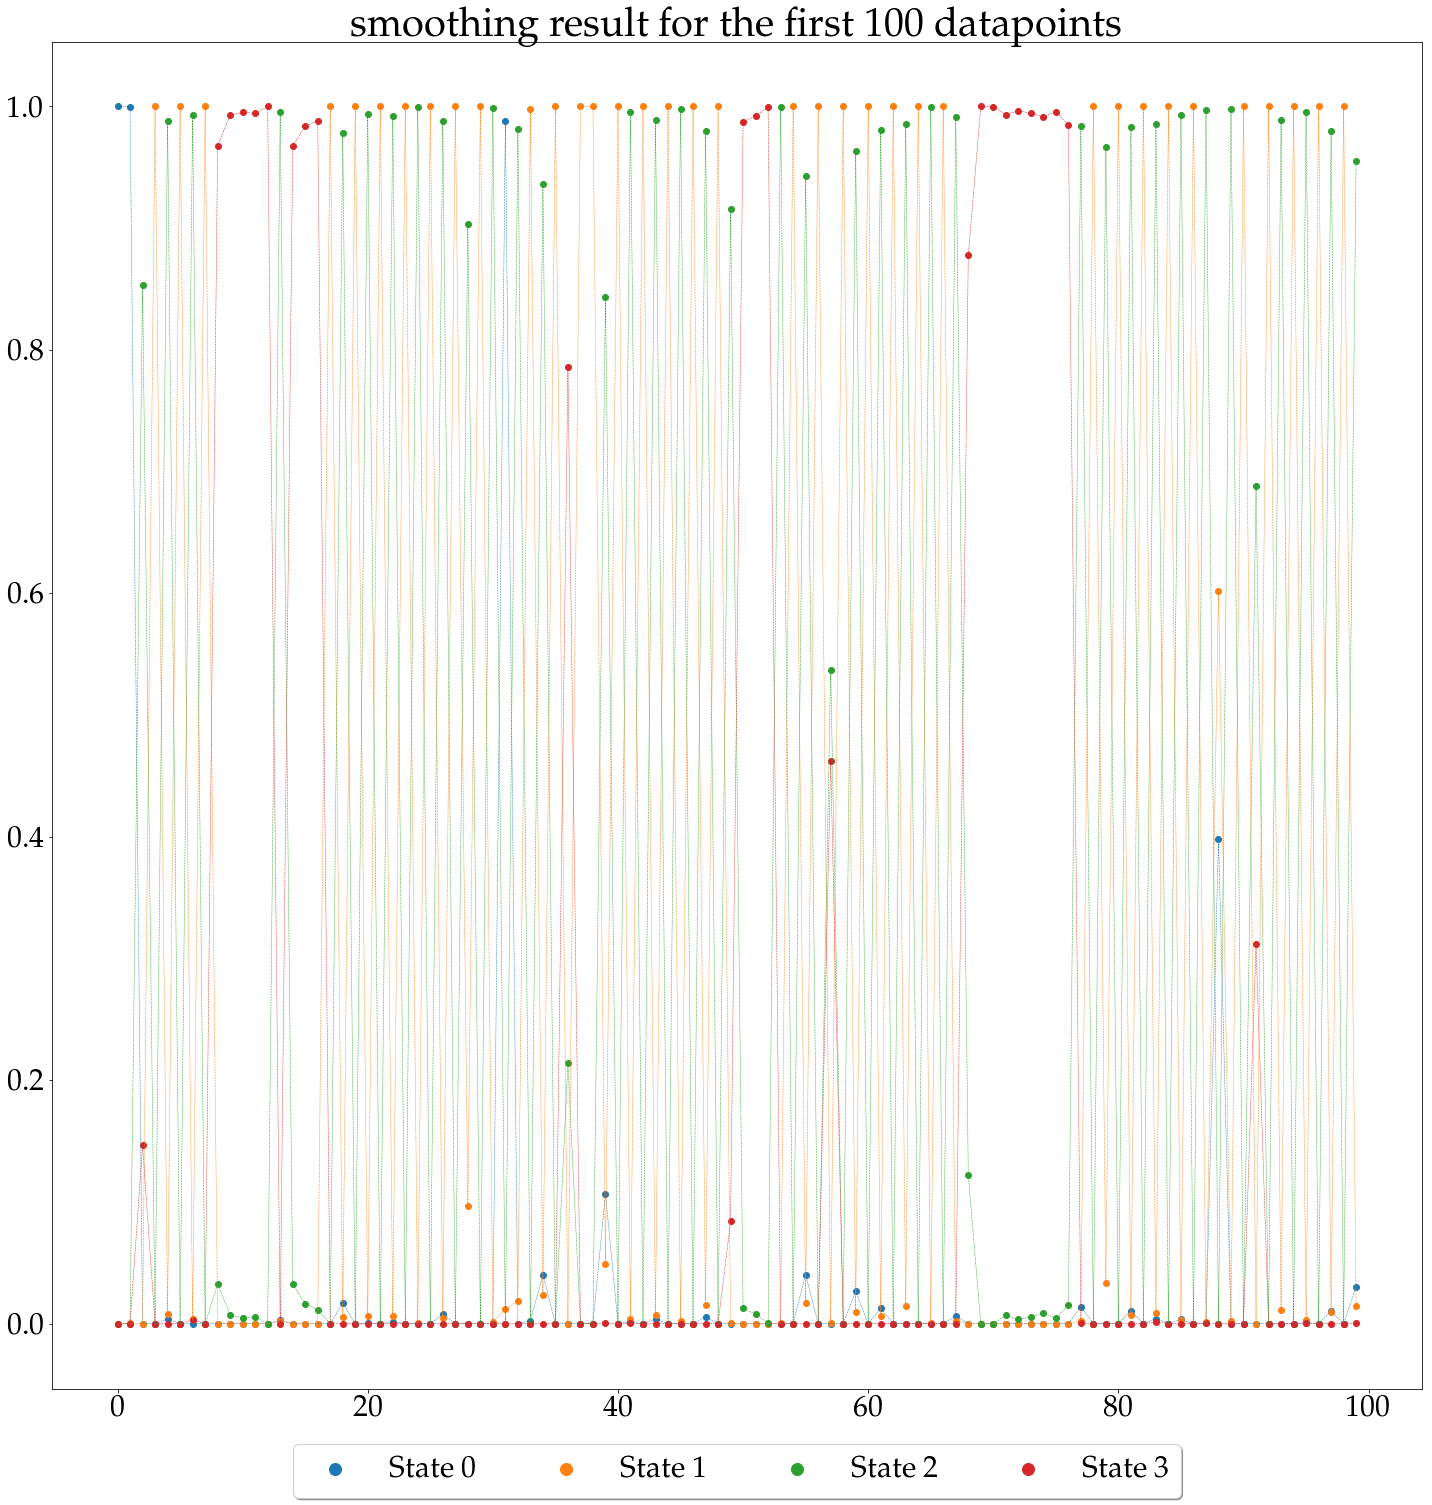

In [258]:
f, ax = plt.subplots(1, figsize = (20, 20))
for i in range(4):
    plt.scatter(np.arange(100), np.exp(smoothing[i, :100]), label = "State {}".format(i))
    plt.plot(np.arange(100), np.exp(smoothing[i, :100]), '--', lw = 0.5)
plt.title("smoothing result for the first 100 datapoints", fontsize = 40)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.03),
            fancybox=True, shadow=True, ncol=4, fontsize = 30,
            markerscale = 2);
f.tight_layout();
# f.savefig("images/2_smoothing.eps", dpi = 300, bbox_inches='tight', pad_inches=1)

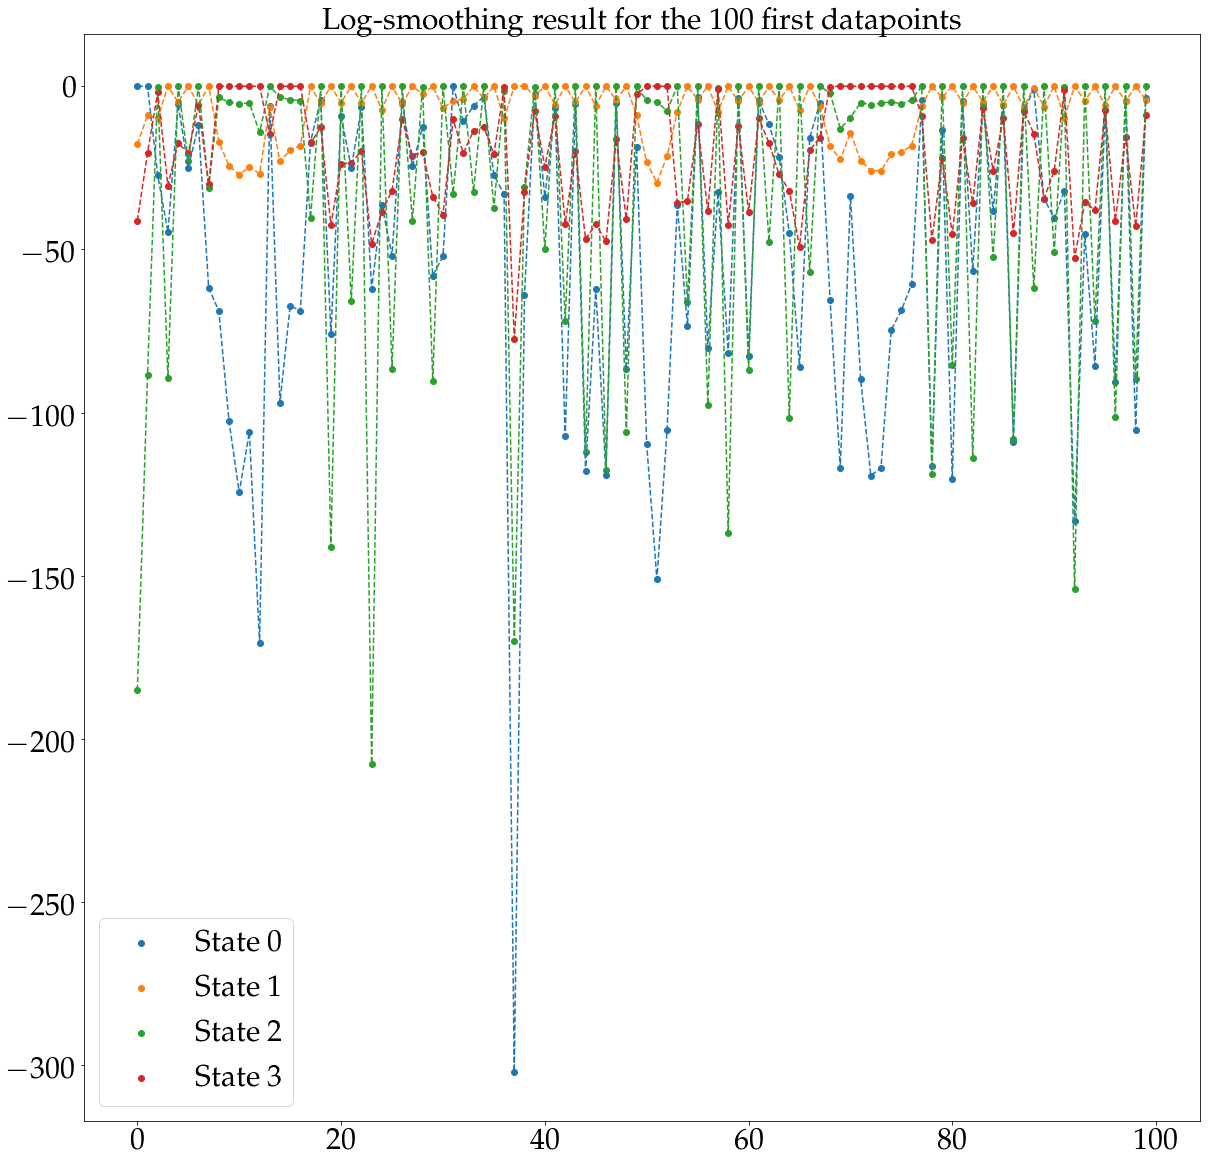

In [259]:
f, ax = plt.subplots(1, figsize = (20, 20))
for i in range(4):
    plt.scatter(np.arange(100), smoothing[i, :100], label = "State {}".format(i))
    plt.plot(np.arange(100), smoothing[i, :100], '--')
plt.title("Log-smoothing result for the 100 first datapoints")
plt.legend();

## 3. Derive the estimation equations of the EM algorithm.

\begin{equation}
\begin{aligned}
\gamma_1^{i, (s+1)} := p(q_1^i = 1 \mid u, \theta^{(s)})\\
\xi^{ij, (s+1)}_{t-1, t} := p\left(q_{t-1}^i = 1, q_t^j = 1 \mid u, \theta^{(s)}\right)\\
\end{aligned}
\end{equation}

\begin{equation}
\begin{aligned}
\widehat{\pi_{i}}^{(s + 1)} &= \gamma_1^{i, (s+1)}\\
	\widehat{A}_{ij}^{(s+1)} &= \frac{\sum_{t=2}^T \xi^{ij, (s+1)}_{t-1, t}}{\sum_{t=2}^T \gamma^{i, (s+1)}_{t-1}} \\
\widehat{\mu_k}^{(s+1)}    & = \frac{\sum_{t = 1}^T \gamma_{t}^{k,(s+1)} u_t}{\sum_{t = 1}^T \gamma_{t}^{k,(s+1)}} \quad \forall k \in [\![1;M]\!]                                                         \\
		\widehat{\Sigma_k}^{(s+1)} & = \frac{\sum_{t = 1}^T \gamma_{t}^{k,(s+1)}\left(u_t - \mu_k\right)\left(u_t - \mu_k\right)^{\intercal}}{\sum_{t = 1}^T \gamma_{t}^{k,(s+1)}} \quad \forall k \in [\![1;M]\!] 
\end{aligned}
\end{equation}

## 4. Derive the estimation equations of the EM algorithm.
Implement the EM algorithm to learn the parameters of the model ($\pi$, $A$, $\mu_k$, $\Sigma_k$, $\forall k = 1 ,\dots, 4)$. The means and covariances could be initialized with the ones ob-
tained in the previous homework. Learn the model from the training data
in“EMGaussienne.dat”.

In [558]:
hmm = HMM(D["test"].as_matrix(), 4, emission, A = A, pi = pi)
hmm._alpha_recursion()
hmm._alpha_norm_recursion()
hmm._beta_recursion()
hmm._smoothing_all()
hmm._gamma_recursion()
hmm._xi_recursion()

alpha = np.exp(hmm.alphas)
beta = np.exp(hmm.betas)
smoothing = hmm.smoothing_all

hmm._EM(A, pi, emission)

-2423.74805067
-2402.04526136
-2401.23493216
-2401.101116


/home/vmatthys/.local/lib/python3.5/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log


-2401.03259099
-2400.9891835
-2400.9611742
-2400.94336474
-2400.93228631
-2400.9255437
-2400.92151791
-2400.91915207
-2400.91777925
-2400.91699051


In [412]:
# Verification of the validity of xis (each squared matrix has to sum to 1)
(np.round(hmm.xis.sum(axis = (1,2)), 3) == 1).all()

True

In [423]:
hmm.xis.sum(0)

array([[  66.12331,    3.85238,    4.14208,    5.061  ],
       [   2.8747 ,    6.05262,  132.88881,   14.0616 ],
       [   6.28093,  129.88408,    4.30305,    7.62348],
       [   3.89983,   16.08864,    6.7576 ,   89.10588]])

In [426]:
hmm.xis.sum(0) / hmm.gammas.sum(1).reshape(-1, 1)

array([[ 0.8247 ,  0.04805,  0.05166,  0.06312],
       [ 0.01844,  0.03883,  0.85252,  0.09021],
       [ 0.04241,  0.87705,  0.02906,  0.05148],
       [ 0.03366,  0.13887,  0.05833,  0.76914]])

In [532]:
params = {
    "mu": np.array([(hmm.gammas[k, :].reshape(-1, 1) * hmm.u).sum(0) / hmm.gammas[k, :].sum() for k in range(4)]),
    "sigma": np.array([(hmm.gammas[k, :].reshape(1, -1) * ((hmm.u - hmm.O[k].mean).T)).dot(hmm.u - hmm.O[k].mean)\
                       / hmm.gammas[k, :].sum()  for k in range(4)])
}

In [507]:
k = 3
(hmm.gammas[k, :].reshape(-1, 1) * hmm.u).sum(0) / hmm.gammas[k, :].sum()

array([ 3.90772, -3.75351])

In [501]:
k = 3
(hmm.gammas[k, :].reshape(-1, 1) * (hmm.u - hmm.O[k].mean).T.dot((hmm.u - hmm.O[k].mean)).sum(0) / hmm.gammas[k, :].sum()

1.55878e+02

In [529]:
k = 3
(hmm.gammas[k, :].reshape(1, -1) * ((hmm.u - hmm.O[k].mean).T)).dot((hmm.u - hmm.O[k].mean)) / hmm.gammas[k, :].sum()

array([[ 1.0059 ,  0.15611],
       [ 0.15611,  1.43548]])

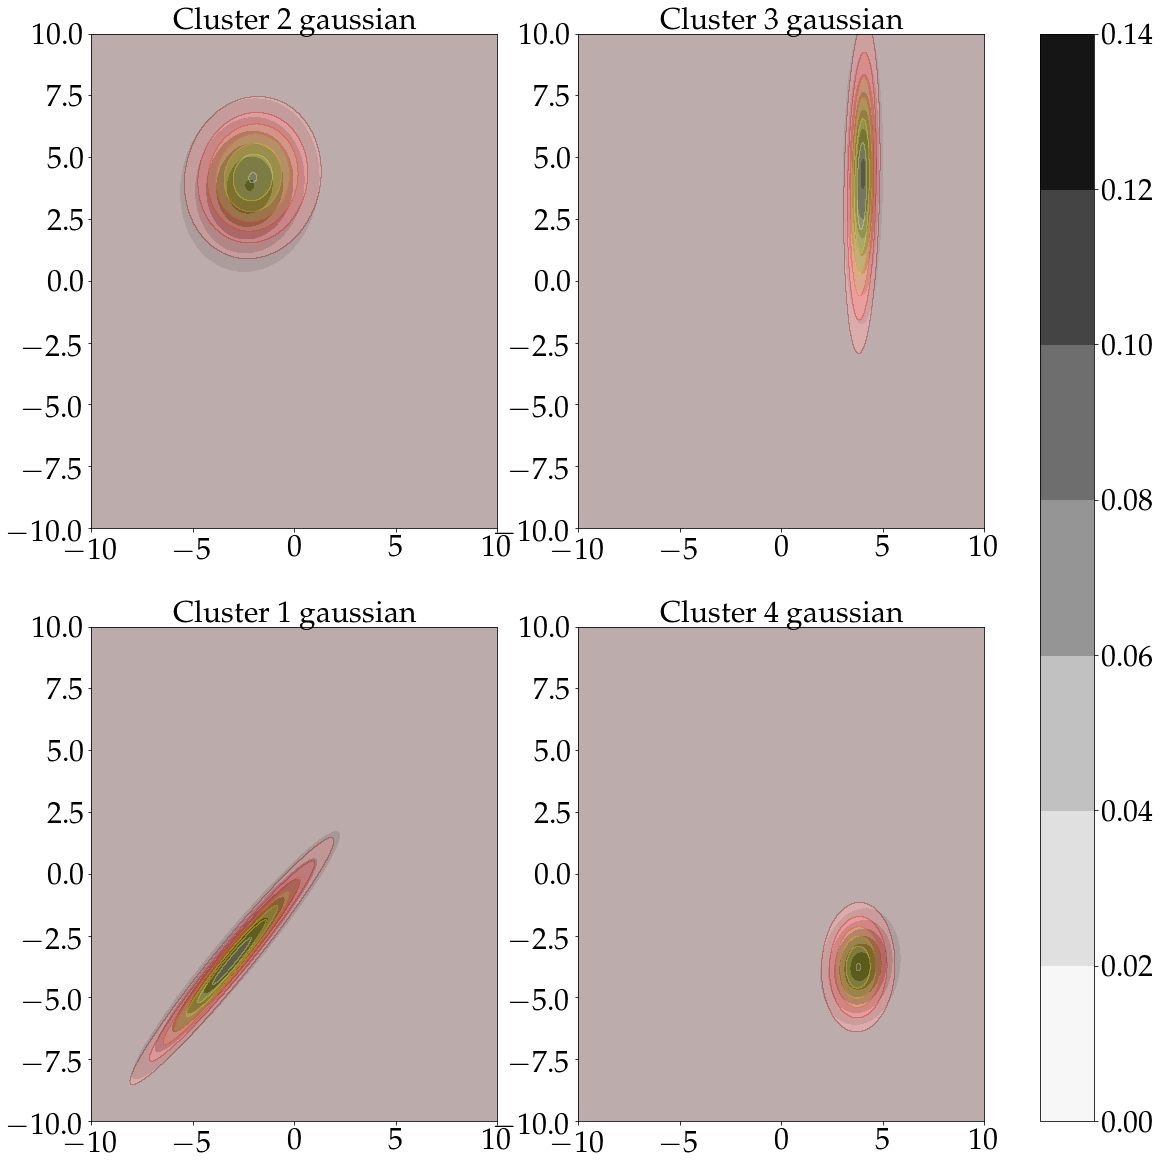

In [540]:
O = np.array([multivariate_normal(params["mu"][key], params["sigma"][key])
           for key in range(params["mu"].shape[0])])
x, y = np.mgrid[-10:10:.01, -10:10:.01]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
cmap = 'Greys'
cmap2 = "hot"

f, ax = plt.subplots(2, 2, figsize = (20, 20));
im1 = ax[1][0].contourf(x, y, O[0].pdf(pos), cmap = cmap);
ax[1][0].contourf(x, y, emission[0].pdf(pos), cmap = cmap2, alpha = 0.3);
ax[1][0].set_title("Cluster 1 gaussian");
ax[0][0].contourf(x, y, O[1].pdf(pos), cmap = cmap);
ax[0][0].contourf(x, y, emission[1].pdf(pos), cmap = cmap2, alpha = 0.3);
ax[0][0].set_title("Cluster 2 gaussian");
ax[0][1].contourf(x, y, O[2].pdf(pos), cmap = cmap);
ax[0][1].contourf(x, y, emission[2].pdf(pos), cmap = cmap2, alpha = 0.3);
ax[0][1].set_title("Cluster 3 gaussian");
im4 = ax[1][1].contourf(x, y, O[3].pdf(pos), cmap = cmap);
ax[1][1].contourf(x, y, emission[3].pdf(pos), cmap = cmap2, alpha = 0.3);
ax[1][1].set_title("Cluster 4 gaussian");
plt.colorbar(im4, ax = ax);

In [545]:
logsumexp(hmm.alphas[:, -1])

-2.42375e+03